# Etap 2 KM 2 - inżynieria cech

In [56]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [20]:
warnings.filterwarnings('ignore')

In [21]:
data = pd.read_csv('../Data/our_data.csv')

In [27]:
X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, stratify=y_val, test_size=0.3, random_state=42
)

cols = X.columns

Podczas procesu EDA zauważyliśmy:
- brak brakujących wartości  
- kolumna Compactness, Area, EquivDiameter zdecydowanie do usunięcia (bardzo duże korelacje)
- brak dużej ilości outlierów (tam wyżej niby były ale to taki rozkład był więc jednak nie)

## 1. Normalizacja
Standaryzacja przy uzyciu MinMaxScaler  
(może poprawiać jakieś rzeczy **dopisać**)

In [37]:
scaling = MinMaxScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)
X_val = scaling.transform(X_val)

X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)
X_val = pd.DataFrame(X_val, columns=cols)

## 2. Encoding
Zamiana zmiennej kategorycznej - nazw klas fasolek, przy użyciu ONE HOT ENCODING

In [38]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.to_frame())
y_encoded = pd.DataFrame(enc.transform(y_train.to_frame()).toarray(),columns=enc.get_feature_names(['Class']))
y_val_encoded = pd.DataFrame(enc.transform(y_val.to_frame()).toarray(),columns=enc.get_feature_names(['Class']))
y_test_encoded = pd.DataFrame(enc.transform(y_test.to_frame()).toarray(),columns=enc.get_feature_names(['Class']))

## 3. Feature Selection
### 3.1 Usunięcie kolumn na podstawie dużej korelacji w EDA

In [39]:
# delete columns with high correlations: Compactness,EquivDiameter, Area
X_train_filtered = X_train.drop(['Compactness','EquivDiameter', 'Area'], axis=1)
X_val_filtered = X_val.drop(['Compactness','EquivDiameter','Area'], axis=1)
X_test_filtered = X_test.drop(['Compactness','EquivDiameter','Area'], axis=1)
cols = X_train.columns
cols

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

### 3.2 Feature importance

Ranking cech: 
Cecha ShapeFactor3 (0.09953792680558517)
Cecha ShapeFactor1 (0.09759661962048836)
Cecha MinorAxisLength (0.09721919057660884)
Cecha MajorAxisLength (0.08887632563914633)
Cecha Compactness (0.08603221280168169)
Cecha Perimeter (0.08017260572255092)
Cecha ConvexArea (0.07552671608139609)
Cecha EquivDiameter (0.06503962048986521)
Cecha AspectRation (0.06265634742566653)
Cecha Eccentricity (0.06246407741813743)
Cecha Area (0.05519114007514214)
Cecha roundness (0.04797018480231234)
Cecha ShapeFactor2 (0.03141893083451229)
Cecha ShapeFactor4 (0.029979953558828713)
Cecha Solidity (0.01393515846440789)
Cecha Extent (0.006382989683670068)


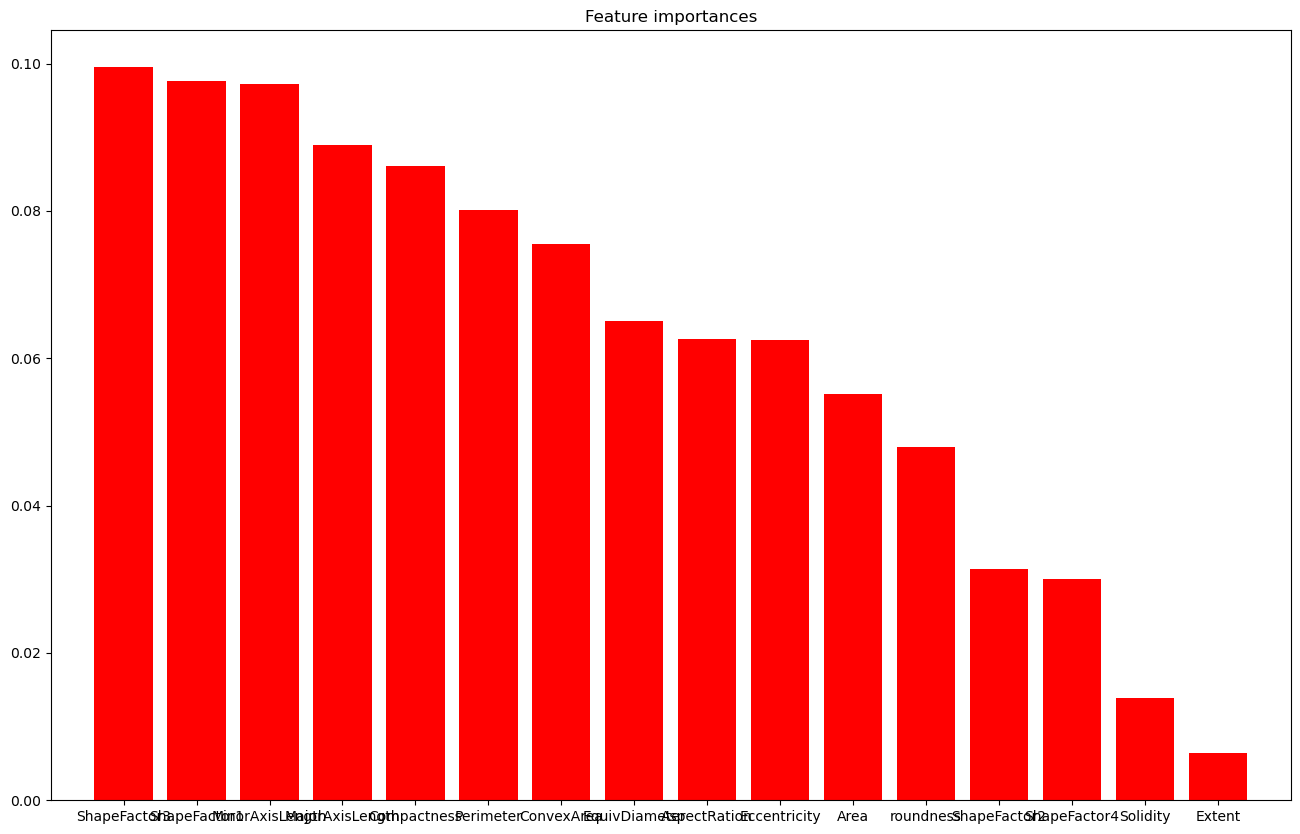

In [50]:
FI_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
FI_clf.fit(X_train, y_encoded)

feature_importances = FI_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in FI_clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]



print("Ranking cech: ")
for i in range(X_train.shape[1]):
    print(f"Cecha {cols[indices[i]]} ({feature_importances[indices[i]]})")

plt.figure(figsize=(16,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), [cols[i] for i in indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
#delete Extent and Solidity
X_train_filtered = X_train_filtered.drop(['Extent','Solidity'], axis=1)
X_val_filtered = X_val_filtered.drop(['Extent','Solidity'], axis=1)
X_test_filtered = X_test_filtered.drop(['Extent','Solidity'], axis=1)

# MODELOWANIE DWUSTOPNIOWE ENCODING - one vs. rest dla fasolki Bombay
Do modelu rozdzielającego Bombay od reszty transformujemy kolumnę zamieniając wartość na 1, gdy jest to bombay 0, gdy nie jest

In [25]:

y_train_b = y_train.map(lambda x: 1 if x == 'BOMBAY' else 0)
y_val_b = y_val.map(lambda x: 1 if x == 'BOMBAY' else 0)
y_test_b = y_test.map(lambda x: 1 if x == 'BOMBAY' else 0)

In [43]:
clf_b = RandomForestClassifier(n_estimators=1, max_depth=100, random_state=42)
clf_b.fit(X_train, y_train_b)
y_val_pred = clf_b.predict(X_val)

accuracy = accuracy_score(y_val_b, y_val_pred)
f1 = sklearn.metrics.f1_score(y_val_b, y_val_pred)
precision = precision_score(y_val_b, y_val_pred)
recall = recall_score(y_val_b, y_val_pred)

report = classification_report(y_val_b, y_val_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Report:", report)

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2201
           1       1.00      1.00      1.00        85

    accuracy                           1.00      2286
   macro avg       1.00      1.00      1.00      2286
weighted avg       1.00      1.00      1.00      2286



BOMBAY  - było tak pięknie przed usunięciem kolumn
n_estimators = 1, max_depth = 100:  
Accuracy: 1.0  
F1 Score: 1.0  
Precision: 1.0  
Recall: 1.0  

n_estimators = 100, max_depth = 3:

Accuracy: 0.9995625546806649  
F1 Score: 0.9940828402366864  
Precision: 1.0  
Recall: 0.9882352941176471  

### 2.2 ONE VS ALL 
w sumie spróbujmy one vs rest dla wszystkich

In [14]:
y_train_s = y_train.map(lambda x: 1 if x == 'SEKER' else 0)
y_val_s = y_val.map(lambda x: 1 if x == 'SEKER' else 0)
y_test_s = y_test.map(lambda x: 1 if x == 'SEKER' else 0)

# Create a RandomForestClassifier model
clf = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train_s)

# Predictions on the validation set
y_val_pred = clf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val_s, y_val_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = sklearn.metrics.f1_score(y_val_s, y_val_pred)
print("F1 Score:", f1)

# Calculate precision
precision = precision_score(y_val_s, y_val_pred)

# Calculate recall
recall = recall_score(y_val_s, y_val_pred)

# Display precision and recall
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9877515310586177
F1 Score: 0.9582089552238807
Precision: 0.9697885196374623
Recall: 0.9469026548672567


SEKER  
n = 30, max = 10 -> 0.6s  
Accuracy: 0.9881889763779528  
F1 Score: 0.9597615499254843  
Precision: 0.9698795180722891  
Recall: 0.9498525073746312  

n = 1, max = 100  
Accuracy: 0.9768153980752406  
F1 Score: 0.9212481426448736  
Precision: 0.9281437125748503  
Recall: 0.9144542772861357  

In [15]:
y_train_d = y_train.map(lambda x: 1 if x == 'DERMASON' else 0)
y_val_d = y_val.map(lambda x: 1 if x == 'DERMASON' else 0)
y_test_d = y_test.map(lambda x: 1 if x == 'DERMASON' else 0)

# Create a RandomForestClassifier model
clf_d = RandomForestClassifier(n_estimators=10, max_depth=70, random_state=42)

# Train the model on the training data
clf_d.fit(X_train, y_train_d)

# Predictions on the validation set
y_val_pred = clf_d.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val_d, y_val_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = sklearn.metrics.f1_score(y_val_d, y_val_pred)
print("F1 Score:", f1)

# Calculate precision
precision = precision_score(y_val_d, y_val_pred)

# Calculate recall
recall = recall_score(y_val_d, y_val_pred)

# Display precision and recall
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9531933508311461
F1 Score: 0.9109075770191507
Precision: 0.916247906197655
Recall: 0.9056291390728477


SPR czy SVM działa lepiej po usunięciu Bombaya:

In [ ]:
#TO FINISH

In [89]:
from sklearn.preprocessing import MinMaxScaler
#TO FINISH - REMOVE ROWS THAT WERE PREDICTED AS BOMBAY BY CLF_B
X_train_filtered = None
y_train_filtered = None
X_val_filtered = None
y_val_filtered = None

#enc = OneHotEncoder(handle_unknown='ignore')
#enc.fit(y_train_filtered.to_frame())
#y_encoded_filtered = pd.DataFrame(enc.transform(y_train_filtered.to_frame()).toarray(),columns=enc.get_feature_names(['Class']))

scaling = MinMaxScaler()
X_train_filtered = scaling.fit_transform(X_train_filtered)

#tu encodowane dane dają błąd 
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1, random_state=42, decision_function_shape='ovo').fit(X_train_filtered, y_train_filtered)
print("SVM accuracy: {:.2f}".format(svm.score(X_val_filtered, y_val_filtered)))
print("SVM f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_filtered, svm.predict(X_val_filtered), average='weighted')))
#uwaga na zmiane parametrow bo moze sie robic kilka dni

ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# kodzenie

### Regresja logistyczna

In [59]:
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
print("BEFORE FEATURE SELECTION:\n")
print(f"Accuracy: {reg.score(X_val, y_val)}")
report = classification_report(y_val, y_pred)
print("Report:\n", report)


cm1 = confusion_matrix(y_val, y_pred)
#print(f"confusion matrix:")
#print(cm)

fig = px.imshow(confusion_matrix(y_val, y_pred),text_auto='.2f')
fig.show()


print("AFTER FEATURE SELECTION:\n")
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train_filtered, y_train)
y_pred = reg.predict(X_val_filtered)
print(f"Accuracy: {reg.score(X_val_filtered, y_val)}")
report = classification_report(y_val, y_pred)
print("Report:\n", report)

#print(f"confusion matrix:")
#print(cm)
cm2 = confusion_matrix(y_val, y_pred)
cm3 = cm2 - cm1

fig = px.imshow(cm3,text_auto='.2f')
fig.show()


BEFORE FEATURE SELECTION:

Accuracy: 0.9146981627296588
Report:
               precision    recall  f1-score   support

    BARBUNYA       0.95      0.89      0.92       222
      BOMBAY       1.00      1.00      1.00        85
        CALI       0.95      0.91      0.93       276
    DERMASON       0.91      0.91      0.91       604
       HOROZ       0.92      0.96      0.94       319
       SEKER       0.94      0.96      0.95       339
        SIRA       0.84      0.85      0.84       441

    accuracy                           0.91      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.92      0.91      0.91      2286



AFTER FEATURE SELECTION:

Accuracy: 0.9146981627296588
Report:
               precision    recall  f1-score   support

    BARBUNYA       0.95      0.89      0.92       222
      BOMBAY       1.00      1.00      1.00        85
        CALI       0.96      0.91      0.93       276
    DERMASON       0.91      0.91      0.91       604
       HOROZ       0.92      0.96      0.94       319
       SEKER       0.94      0.96      0.95       339
        SIRA       0.84      0.85      0.84       441

    accuracy                           0.91      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.92      0.91      0.91      2286



### SVM

In [58]:
#tu encodowane dane dają błąd 
svm = SVC(kernel='linear', C=1, random_state=42, decision_function_shape='ovo').fit(X_train, y_train)
print("SVM accuracy: {:.2f}".format(svm.score(X_val, y_val)))
print("SVM f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val, svm.predict(X_val), average='weighted')))
#uwaga na zmiane parametrow bo moze sie robic kilka dni
y_pred = svm.predict(X_val)
report = classification_report(y_val, y_pred)
print("Report:\n", report)

cm1 = confusion_matrix(y_val, y_pred)
#print(f"confusion matrix:")
#print(cm)

fig = px.imshow(confusion_matrix(y_val, y_pred),text_auto='.2f')
fig.show()


print("AFTER FEATURE SELECTION:\n")
svm = SVC(kernel='linear', C=1, random_state=42, decision_function_shape='ovo').fit(X_train_filtered, y_train)
print("SVM accuracy: {:.2f}".format(svm.score(X_val_filtered, y_val)))
print("SVM f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val, svm.predict(X_val_filtered), average='weighted')))
y_pred = svm.predict(X_val_filtered)

report = classification_report(y_val, y_pred)
print("Report:\n", report)

#print(f"confusion matrix:")
#print(cm)
cm2 = confusion_matrix(y_val, y_pred)
cm3 = cm2 - cm1

fig = px.imshow(cm3,text_auto='.2f')
fig.show()

SVM accuracy: 0.92
SVM f1 score: 0.92
Report:
               precision    recall  f1-score   support

    BARBUNYA       0.96      0.90      0.93       222
      BOMBAY       1.00      1.00      1.00        85
        CALI       0.95      0.91      0.93       276
    DERMASON       0.92      0.92      0.92       604
       HOROZ       0.92      0.96      0.94       319
       SEKER       0.95      0.96      0.96       339
        SIRA       0.85      0.85      0.85       441

    accuracy                           0.92      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.92      0.92      0.92      2286



AFTER FEATURE SELECTION:

SVM accuracy: 0.92
SVM f1 score: 0.92
Report:
               precision    recall  f1-score   support

    BARBUNYA       0.96      0.90      0.93       222
      BOMBAY       1.00      1.00      1.00        85
        CALI       0.94      0.91      0.93       276
    DERMASON       0.92      0.92      0.92       604
       HOROZ       0.92      0.96      0.94       319
       SEKER       0.95      0.96      0.96       339
        SIRA       0.85      0.86      0.85       441

    accuracy                           0.92      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.92      0.92      0.92      2286



SVM accuracy: 0.92
SVM f1 score: 0.92

### DecisionTreeClassifier

In [57]:
#tree
print("ENCODED")
tree = DecisionTreeClassifier(max_depth=10000, random_state=42)
tree.fit(X_train, y_encoded)
y_hat = tree.predict(X_val)
print("Tree accuracy: {:.2f}".format(tree.score(X_val, y_val_encoded)))
print("Tree f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_encoded, y_hat, average='weighted')))
report = classification_report(y_val, y_pred)
print("Report:\n", report)

y_hat = enc.inverse_transform(y_hat)
cm1 = confusion_matrix(y_val, y_hat)
#print(f"confusion matrix:")
#print(cm)

fig = px.imshow(confusion_matrix(y_val, y_hat),text_auto='.2f')
fig.show()

print("AFTER FEATURE SELECTION:\n")



ENCODED
Tree accuracy: 0.89
Tree f1 score: 0.89
Report:
               precision    recall  f1-score   support

    BARBUNYA       0.96      0.90      0.93       222
      BOMBAY       1.00      1.00      1.00        85
        CALI       0.94      0.91      0.93       276
    DERMASON       0.92      0.92      0.92       604
       HOROZ       0.92      0.96      0.94       319
       SEKER       0.95      0.96      0.96       339
        SIRA       0.85      0.86      0.85       441

    accuracy                           0.92      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.92      0.92      0.92      2286



AFTER FEATURE SELECTION:



Tree accuracy: 0.89  
Tree f1 score: 0.89

In [63]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=10000, random_state=42, criterion='gini')
tree.fit(X_train, y_encoded)
y_hat = tree.predict(X_val)
print("Tree accuracy: {:.2f}".format(tree.score(X_val, y_val_encoded)))
print("Tree f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_encoded, y_hat, average='weighted')))

Tree accuracy: 0.89
Tree f1 score: 0.89


### Random Forest

In [64]:
#random forest
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=42, criterion='gini')
forest.fit(X_train, y_encoded)
y_hat = forest.predict(X_val)
print("Forest accuracy: {:.2f}".format(forest.score(X_val, y_val_encoded)))
print("Forest f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_encoded, y_hat, average='weighted')))

Forest accuracy: 0.91
Forest f1 score: 0.92


In [87]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=42, criterion='gini')
forest.fit(X_train, y_train)
y_hat = forest.predict(X_val)
print("Forest accuracy: {:.2f}".format(forest.score(X_val, y_val)))
print("Forest f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val, y_hat, average='weighted')))

cm = confusion_matrix(y_val, y_hat)
#print(f"confusion matrix:")
#print(cm)

fig = px.imshow(confusion_matrix(y_val, y_hat),text_auto='.2f')
fig.show()

Forest accuracy: 0.92
Forest f1 score: 0.92
confusion matrix:
[[203   0   6   0   3   2   8]
 [  0  85   0   0   0   0   0]
 [ 16   0 244   0  11   1   4]
 [  0   0   0 555   1   8  40]
 [  2   0   6   1 302   0   8]
 [  2   0   0   5   0 325   7]
 [  2   0   1  48   6   3 381]]


Niezakodowane dane dają lepszy wynik?